In [1]:
from systemml import MLContext, dml, jvm_stdout
ml = MLContext(sc)
print(ml.info())
sc.version

Archiver-Version: Plexus Archiver
Artifact-Id: systemml
Build-Jdk: 1.8.0_144
Build-Time: 2017-09-21 22:44:37 UTC
Built-By: romeokienzler
Created-By: Apache Maven 3.3.9
Group-Id: org.apache.systemml
Main-Class: org.apache.sysml.api.DMLScript
Manifest-Version: 1.0
Minimum-Recommended-Spark-Version: 2.1.0
Version: 1.0.0-SNAPSHOT



u'2.1.0'

In [2]:
#! pip install --upgrade http://www.romeokienzler.com/systemml-1.0.0-SNAPSHOT-python.tar.gz 

In [2]:
import pickle

In [ ]:
!wget http://www.romeokienzler.com/watsoniotp.healthy.pickle
!wget http://www.romeokienzler.com/watsoniotp.broken.pickle

In [3]:
data_healthy = pickle.load(open('watsoniotp.healthy.pickle', 'rb'))
data_broken = pickle.load(open('watsoniotp.broken.pickle', 'rb'))

In [4]:
data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

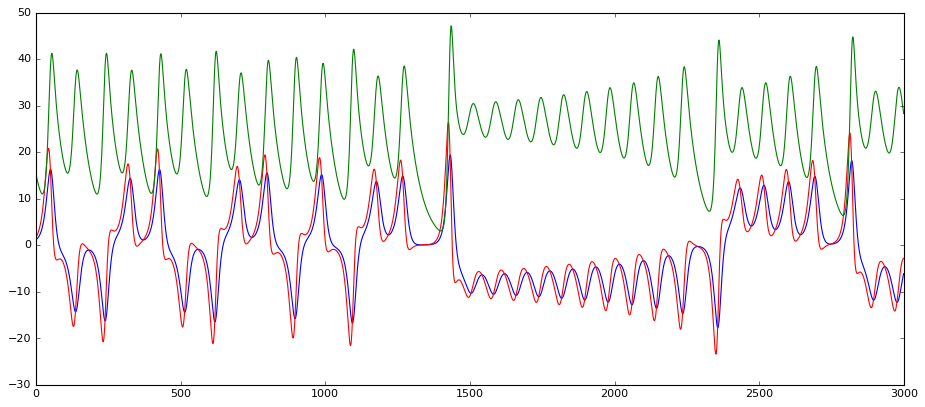

In [6]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_healthy[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,2], '-', color='green', animated = True, linewidth=1)

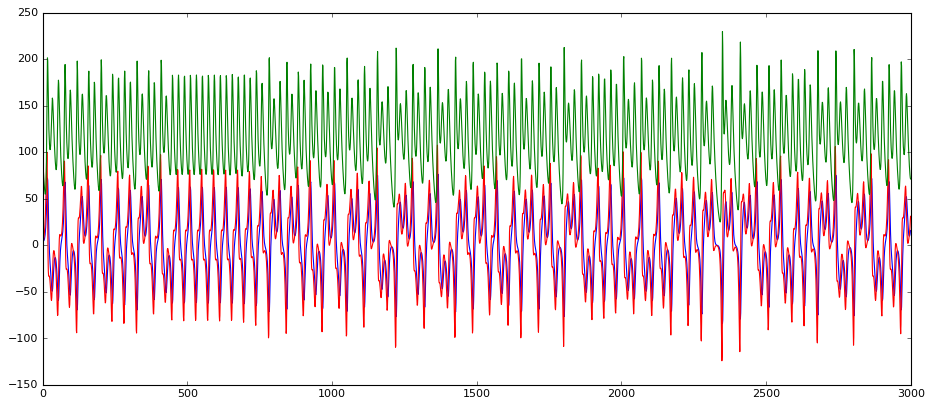

In [7]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_broken[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,2], '-', color='green', animated = True, linewidth=1)

In [7]:
import numpy as np
data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

/gpfs/fs01/user/se2e-1a118c4f322670-980ba6aaa6c3/.local/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


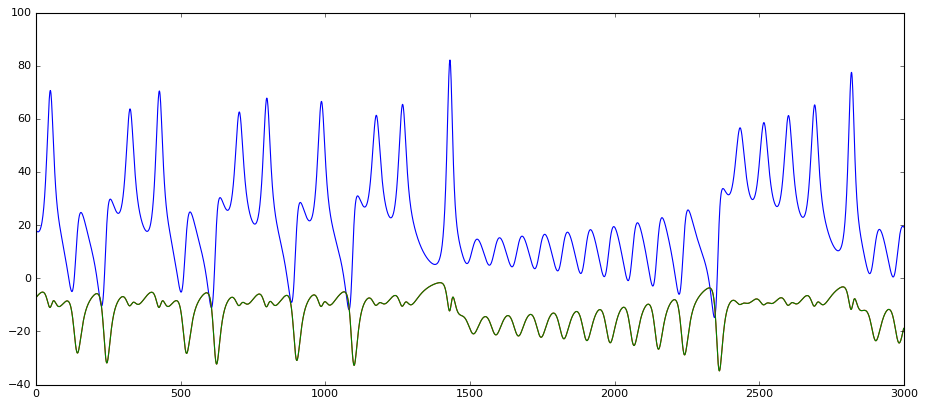

In [9]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_healthy_fft[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2], '-', color='green', animated = True, linewidth=1)


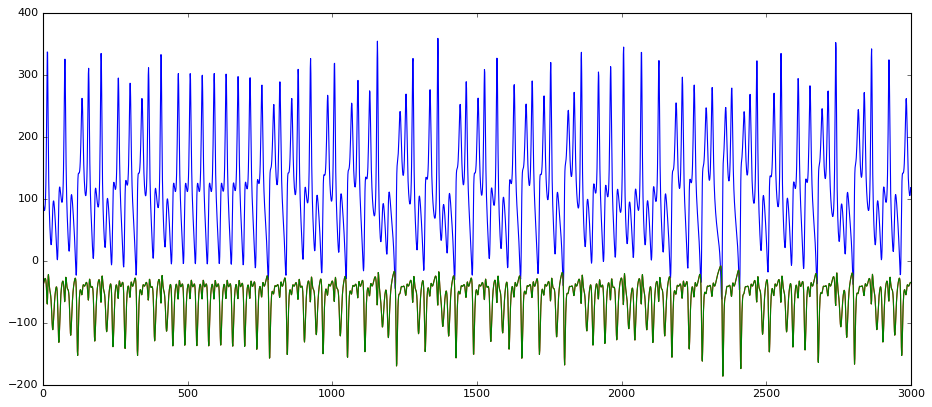

In [10]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_broken_fft[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2], '-', color='green', animated = True, linewidth=1)

In [8]:
script = """
source("nn/layers/affine.dml") as affine
source("nn/layers/conv2d_builtin.dml") as conv2d
source("nn/layers/cross_entropy_loss.dml") as cross_entropy_loss
source("nn/layers/l2_loss.dml") as l2_loss
source("nn/layers/dropout.dml") as dropout
source("nn/layers/l2_reg.dml") as l2_reg
source("nn/layers/max_pool2d_builtin.dml") as max_pool2d
source("nn/layers/relu.dml") as relu
source("nn/layers/softmax.dml") as softmax
source("nn/layers/sigmoid.dml") as sigmoid
source("nn/optim/sgd_nesterov.dml") as sgd_nesterov
source("nn/optim/rmsprop.dml") as rmsprop
#
inputLayerSize = 3000
outputLayerSize = 3000
hiddenLayer1Size = 100


Xt = t(X)

n = nrow(Xt)
means = colSums(Xt)/n
stds = sqrt((colSums(Xt^2)/n - means*means)*n/(n-1)) + 1e-17
Xt = (Xt - means)/stds

Xt = 1/(1+exp(-Xt))

y = Xt

[W1, b1] = affine::init(inputLayerSize, hiddenLayer1Size)
[W2, b2] = affine::init(hiddenLayer1Size, outputLayerSize) 

if (pushWeights) {
    W1 = W1push
    W2 = W2push
}  


feedForward = function (matrix[double] X,
                        matrix[double] b1,
                        matrix[double] b2,
                        matrix[double] W1,
                        matrix[double] W2
                        ) 
                        return (matrix[double] z2,
                        matrix[double] a2,
                        matrix[double] z3,
                        matrix[double] Y) {
    z2 = affine::forward(X, W1, b1)
    a2 = sigmoid::forward(z2)
    z3 = affine::forward(a2, W2, b2)
    Y = sigmoid::forward(z3)
}

gradient = function(matrix[double] X,
                        matrix[double] b1,
                        matrix[double] b2,
                        matrix[double] W1,
                        matrix[double] W2,
                        matrix[double] Y) #{
                        return (matrix[double] dJdW1,
                        matrix[double] dJdW2
                        ) {
    #Compute derivative with respect to W and W2 for a given X and y:
    [z2,a2,z3,Yhat] = feedForward(X,b1,b2,W1,W2)
    
    loss = l2_loss::backward(Yhat, Y)
    
    smpz3 =  sigmoid::backward(loss,z3) 
    [delta2,dJdW2,db2] = affine::backward(smpz3,a2,W2,b2)
                
    smpz2 =  sigmoid::backward(delta2,z2)
    [delta2,dJdW1,db1] = affine::backward(smpz2,X,W1,b1)
}

upd_W1 = matrix(0, rows=nrow(W1), cols=ncol(W1))
upd_W2 = matrix(0, rows=nrow(W2), cols=ncol(W2))

max_iterations = 10000
iter = 0
learningRate = 0.001

while( iter < max_iterations ){
      [dJdW1, dJdW2] = gradient(Xt,b1,b2,W1,W2,y)

      #update
      lrdJdW1 = learningRate * dJdW1
      lrdJdW2 = learningRate * dJdW2
      W1 = W1 - lrdJdW1
      W2 = W2 - lrdJdW2
      
      iter = iter + 1
      if (iter %% 100 == 0) {
          #[z2,a2,z3,a3,z4,Yhat] = feedForward(Xt,b1,b2,b3,W1,W2,W3)
          [z2,a2,z3,Yhat] = feedForward(Xt,b1,b2,W1,W2)
          sse = sqrt(sum((Xt-Yhat)^2))
          print(sse)
      }
}
"""

In [10]:
dummyMatrix = np.array([[1],[1]])
with jvm_stdout(True):
    prog = dml(script).input(X=data_healthy_fft).input(pushWeights=False).input(W1push=dummyMatrix).input(W2push=dummyMatrix)
    result = ml.execute(prog)
    [W1, W2] = result.get("W1", "W2")
    prog = dml(script).input(X=data_healthy_fft).input(pushWeights=True).input(W1push=W1).input(W2push=W2)
    result = ml.execute(prog)
    [W1, W2] = result.get("W1", "W2")
    prog = dml(script).input(X=data_broken_fft).input(pushWeights=True).input(W1push=W1).input(W2push=W2)
    result = ml.execute(prog)


18.022310535685214
17.944409097995415
17.916457561971384
17.89999891169232
17.887692254014823
17.87714780026466
17.867343027818603
17.85775391534591
17.848072029118896
17.83809320290641
17.82766740309283
17.816673701444362
17.80500671472224
17.792568754725824
17.779265027775683
17.765000537158997
17.749677948498576
17.73319599991797
17.71544824193758
17.696322030382156
17.675697778098826
17.653448499850125
17.629439675818716
17.603529442982325
17.575569125591013
17.54540413822741
17.51287531825419
17.477820749899987
17.440078126144233
17.399487665056913
17.355895567317155
17.309157987051
17.259145498210092
17.205748055652073
17.14888042687584
17.088487977624805
17.024552569417573
16.95709823990472
16.886196312364337
16.811969588886804
16.73459529511114
16.654306464965476
16.571391497081752
16.48619168989389
16.399096669142036
16.31053775108219
16.220979424595384
16.130909272124196
16.040826769565033
15.951231495712895
15.862611331070921
15.775431226957888
15.690123079022468
15.60707715

In [13]:
script="""
source("nn/layers/cross_entropy_loss.dml") as cross_entropy_loss
source("nn/layers/l2_loss.dml") as l2_loss

source("nn/layers/lstm.dml") as lstm
source("nn/layers/sigmoid.dml") as sigmoid

source("nn/optim/sgd_nesterov.dml") as sgd_nesterov
source("nn/optim/rmsprop.dml") as rmsprop


in_TS = 70 #in_TS
out_TS = 30 #out_TS
N = nrow(X) / (in_TS + out_TS)
M = out_TS

idx_mat = outer(seq(0,N-1,1), t(seq(0,in_TS+out_TS-1,1)), "+") + 1

idx_col = matrix(idx_mat, rows=nrow(idx_mat)*ncol(idx_mat), cols=1)
rordrd_X = table(seq(1, nrow(idx_col), 1), idx_col, nrow(idx_col), nrow(idx_col)) %*% X

X = matrix(rordrd_X, rows=nrow(idx_mat), cols=ncol(idx_mat))
#print(toString(X))

Y = X[,in_TS+1:in_TS+out_TS]
X = X[,1:in_TS]

max_iterations = 1000
iter = 0
learningRate = 0.01
decayRate = 0.95

[W, b, out0, c0] = lstm::init(N,1,M)

if (pushWeights) {
    W = Wpush
} 


rmspropCache = rmsprop::init(W)

while( iter < max_iterations ){
    [a1, c, c_out, c_c, c_ifog] = lstm::forward(X, W, b, in_TS, 1, FALSE, out0, c0)
    loss = l2_loss::forward(a1, Y)

    if(iter %% 100 == 0) print("iter=" + iter + " loss=" + loss)
    
    loss_grad = l2_loss::backward(a1, Y)
    [dX, dW, db, dout0, dc0] = lstm::backward(loss_grad, c0, X, W, b, in_TS, 1, FALSE, out0, c0, c_out, c_c, c_ifog)

    [W, rmspropCache] = rmsprop::update(W, dW, learningRate, decayRate, 1e-6, rmspropCache)
    
    iter = iter + 1
}

"""

  

In [14]:
import numpy as np
dummyW = np.array([[1],[1]])
with jvm_stdout(True):
    prog = dml(script).input(X=np.transpose(np.array([data_healthy[:,1]]))).input(pushWeights=False).input(Wpush=dummyW)
    result = ml.execute(prog)
    W = result.get("W")
    prog = dml(script).input(X=np.transpose(np.array([data_healthy[:,1]]))).input(pushWeights=True).input(Wpush=W)
    result = ml.execute(prog)
    W = result.get("W")
    prog = dml(script).input(X=np.transpose(np.array([data_broken[:,1]]))).input(pushWeights=True).input(Wpush=W)
    result = ml.execute(prog)  

iter=0 loss=687.5261156735979
iter=100 loss=530.6986597166643
iter=200 loss=530.6460810916589
iter=300 loss=530.6417329491396
iter=400 loss=530.6413225895424
iter=500 loss=530.6412874536686
iter=600 loss=530.6412843344015
iter=700 loss=530.641283831329
iter=800 loss=530.6412836727067
iter=900 loss=530.6412835964422
SystemML Statistics:
Total execution time:		111.192 sec.
Number of executed Spark inst:	2.

iter=0 loss=530.6412835516305
iter=100 loss=530.6412835222125
iter=200 loss=530.6412835014875
iter=300 loss=530.6412834861044
iter=400 loss=530.6412834742773
iter=500 loss=530.6412834648622
iter=600 loss=530.6412834571842
iter=700 loss=530.6412834507993
iter=800 loss=530.6412834454042
iter=900 loss=530.6412834407836
SystemML Statistics:
Total execution time:		110.612 sec.
Number of executed Spark inst:	1.

iter=0 loss=23928.246296745765
iter=100 loss=23449.966064892516
iter=200 loss=23449.712938233795
iter=300 loss=23449.580740646383
iter=400 loss=23449.475229445376
iter=500 loss=2344

In [ ]:
#!pip install ibmiotf

In [4]:
import ibmiotf.application

In [5]:
options = {"org": "rwyrty", "id": "anything", "auth-method": "apikey", "auth-key": "a-rwyrty-f95d3ji16n", "auth-token": "ZHd1&O)_J1&TI4XP3z"}


In [6]:
client = ibmiotf.application.Client(options)
client.connect()


2017-10-03 06:17:50,886   ibmiotf.application.Client  INFO    Connected successfully: a:rwyrty:anything


In [7]:
from Queue import Queue
q = Queue(7000)

In [8]:
def myEventCallback(event):
    q.put(event.data)

In [9]:
client.deviceEventCallback = myEventCallback
client.subscribeToDeviceEvents("0.16.2", "lorenz", "osc")

True

In [10]:
import numpy as np
global firstCall
firstCall = True
global W
W = np.array([[1],[1]])
def doNN(data):
    with jvm_stdout(True):
        global firstCall
        global W
        notFirstCall = not firstCall
        prog = dml(script).input(X=np.transpose(np.array([data[:,1]]))).input(pushWeights=notFirstCall).input(Wpush=W)
        result = ml.execute(prog)
        W = result.get("W")
        firstCall = False

In [ ]:
import numpy as np
while True:
    while not q.empty():
        sample = q.get()
        point = [sample["x"], sample["y"],sample["z"]]
        try:
            data
        except NameError:
            data = np.array(point)
        else:
            data = np.append(data,point)
        if data.size>=9000:
            data = np.reshape(data,(3000,3))
            print data
            doNN(data)
            del data


[[  6.11969518  11.54449163  11.36151056]
 [  6.55367889  12.32448224  11.76529726]
 [  7.01534316  13.13702247  12.25159002]
 ..., 
 [  8.24893623  14.06110522  16.70710014]
 [  8.71390975  14.73585886  17.37793756]
 [  9.19566568  15.39938747  18.14006918]]
iter=0 loss=2413.858755066755
iter=100 loss=2057.9850708044146
iter=200 loss=2057.915666845763
iter=300 loss=2057.910476889281
iter=400 loss=2057.9100639433464
iter=500 loss=2057.9100307954836
iter=600 loss=2057.9100277469784
iter=700 loss=2057.9100272660107
iter=800 loss=2057.91002714405
iter=900 loss=2057.910027095842
SystemML Statistics:
Total execution time:		109.745 sec.
Number of executed Spark inst:	2.


[[-13.27659597 -14.23889727  32.55798112]
 [-13.35358007 -13.63806316  33.32034661]
 [-13.37633872 -12.95962459  33.99633117]
 ..., 
 [ -7.11393407 -12.47767269  14.82560282]
 [ -7.54303316 -13.17285063  15.30422928]
 [ -7.99341856 -13.8793287   15.86528533]]
iter=0 loss=1163.6412893153808
iter=100 loss=1163.6412893144914
i

In [ ]:
q.qsize()

In [ ]:
del data

In [ ]:
data.size